# Tarea 3 - Reticulados


## Código de Honor
Me comprometo a hacer esta tarea por mi cuenta y por mis propios medios:



In [197]:
firma = 'Maximiliano Ruz'
print(firma)

Maximiliano Ruz


Completar este programa para determinar las fuerzas y reacciones en un
reticulado segun lo visto en clases. La tarea sera evaluada con un
reticulado arbitrario.

Bonus: se premiara con 0.3 puntos del curso al que incorpore en su codigo alguna
forma de mostrar los resultados en un grafico. Puede ser distintos colores, o con numeros.
Queda a discreción del profesor la cantidad del puntaje asignado, segun la calidad del gráfico.



In [198]:
!git clone https://github.com/fsahli/TareaReticulado

fatal: destination path 'TareaReticulado' already exists and is not an empty directory.


In [199]:
%load_ext autoreload
%autoreload 2
from TareaReticulado.Truss import * # Importa el modulo con las funciones
filename='TareaReticulado/truss-hyper.in'; #nombre del archivo con la informacion del reticulado

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
import numpy as np

tr=Truss(filename)

[[0.  0. ]
 [1.  0. ]
 [2.  0. ]
 [0.5 1. ]
 [1.5 1. ]]
[[0 1]
 [1 2]
 [0 3]
 [3 1]
 [1 4]
 [4 2]
 [3 4]]
[[0 1 0]
 [0 0 1]
 [2 1 0]
 [2 0 1]]
[[   3.    0. -500.]
 [   4.    0. -500.]]


Se genera un objeto `Truss`, que tiene los siguientes atributos:

- `tr.nodes [nro de nodos,2]`: tiene la posicion X,Y de cada nodo en el mismo
orden en que fueron especificados en el archivo.
- `tr.bars [nro de barras,2]`: contiene el numero de cada nodo que esta
presente en la barra
- `tr.reac [nro de reacciones, 3]`: en la primera columna tiene los nodos en los
que esta aplicada la reaccion. La 2da y 3ra corresponden a un vector
unitario especificando la direccion de la reaccion. El número de nodo en que está aplicada la fuerza puede venir en `float`. Hay que convertirlo a `int` para usarlo como índice: `i = int(f)`.
- `tr.force [nro de fuerzas,3]`: en la primera columna tiene los nodos en los
que esta aplicada la fuerza. La 2da y 3ra corresponden a un vector
especificando la fuerza. Ojo!! El número de nodo en que está aplicada la fuerza puede venir en `float`. Hay que convertirlo a `int` para usarlo como índice: `i = int(f)`.

Además cuenta con las funciones:

- `tr.plot`: dibuja el reticulado. En negro se grafican las restricciones
en rojo las fuerzas. Los vectores estan dibujados de manera que siempre apuntan al nodo.
- `tr.X(i,j)` retorna el coeficiente X.
- `tr.Y(i,j)` retorna el coeficiente Y.

## Caso hiperestático

Utilizando el codigo desarrollado del reticula isoestático, genere un programa que
calcule la posicion desformada de un reticulado cualquiera, especificado
en un archivo con la estructura de prueba.in.

Por simplicidad solo se considerarán reacciones en el sistema coordenado
x-y. Ej: [1 0] o [0 1]. Considere además que el reticulado puede ser hiperestatico.

Como guia considere que debe generar la matriz `A` y la matriz `k`. Luego
resolver `A*km*A'*dx=f`, considerando que hay algunas ecuaciones que no
pueden ser resueltas directamente.

_dx_ : delta x 

Considere para las barras un modulo elastico E=200 GPa y que son cilindricas
con un radio de 5 mm.

Como resultado genere un vector `R` que contenga el resultado de las
reacciones desconocidas en el mismo orden con el que fueron planteadas,
un vector `F` con todas las fuerzas de las barras en orden 
un vector `DX` con los desplazamientos de todos los nodos (incluidos los que son cero), 
respetando el orden en
que fueron planteados. Para escribir los resultados utilize la función
`tr.write_results(DX,R,F,'output.txt')`

### Funciones utilizadas:

Generar el vector de fuerzas **f** :

In [201]:
def generate_f(tr: Truss) -> np.ndarray:

  f=np.zeros(2*len(tr.nodes))   # vector f contiene el resultado de  K * dx (con K: matriz de rigidez global = -At k A, y dx: delta x)

  # Agregar todas las fuerzas externas en el vector fc:
  for force in tr.force:

    index = int(force[0]) #Nodo en donde esta ubicada la fuerza

    f[2*index] = force[1]  # Fuerza en x
    f[2*index + 1] = force[2] # Fuerza en y

  return f

Generar la matriz **A** : 

In [202]:
def generate_A(tr: Truss) -> np.ndarray:

  A=np.zeros((2*len(tr.nodes),len(tr.bars)))    # A es de la forma (# fuerzas en x + # fuerzas en y) x (# barras [una fuerza por cada barra])

  # Codigo del profesor Sahli, alterado:

  for k, bar in enumerate(tr.bars):    
    i = bar[0]
    j = bar[1]

    A[2*i, k] = tr.X(i, j)
    A[2*i+1, k] = tr.Y(i, j)
    A[2*j, k] = tr.X(j, i)
    A[2*j+1, k] = tr.Y(j, i)

    #originalmente tenía este código, pero los resultados me dierón de signos contrarios al del profesor.
    # Si se descomenta, las fuerzas cambiaran de signo:
    # A[2*i, k] = tr.X(j, i)
    # A[2*i+1, k] = tr.Y(j, i)
    # A[2*j, k] = tr.X(i, j)
    # A[2*j+1, k] = tr.Y(i, j)

  return A

Generar la matriz de rigidez **km** :

In [203]:
# Funcion calcula la rigidez de cada barra:

def get_stiffness(tr: Truss, coordinates: list) -> float:

  E=200E9;  # Modulo de Young para todas las barras
  area=5e-3**2*np.pi;  # Todas las barras tienen igual area

  i = coordinates[0]
  j = coordinates[1]

  lenght = (np.sqrt((tr.nodes[i,0] - tr.nodes[j,0]) ** 2 + (tr.nodes[i, 1] - tr.nodes[j,1]) ** 2))  # Linea de codigo sacada del metodo X, de la clase Truss y alterada
  
  stiffness = (E * area) / lenght

  return stiffness

# Funcion que nos entrega km:

def generate_km(tr: Truss):

  km = np.zeros((len(tr.bars),len(tr.bars)))  # Matriz de rigidez local (creo que se llama asi)

  for k, bar in enumerate(tr.bars):
    
    km[k , k] = get_stiffness(tr, bar)

  return km

Calcular la matriz de rigidez global **K** :

In [204]:
def generate_K(A: np.ndarray, km: np.ndarray ) -> np.ndarray:

    return A.dot(km.dot(A.T))


Ordenar la matrix de rigidez **K** de tal manera que las ecuaciones que contienen reacciones queden arriba de las que no.

In [205]:
#Funcion que reciba una lista y una lista de tuplas (a,b), cada tupla representa un intercambio de filas. La fila a se intercambia con la fila b.

def swap_rows(lista: list, combinatios_list: list[tuple])-> None:

    for combination in combinatios_list:
        
        a = combination[0]
        b = combination[1]

        if type(lista[a]) not in [list, np.ndarray]:

            aux_list = lista[a]
            lista[a] = lista[b]
            lista[b] = aux_list

        else:

            aux_list = lista[a].copy()
            lista[a] = lista[b].copy()
            lista[b] = aux_list


#Funcion que revisa si las primeras n filas presentan reacciones:

def check_reaction(lista: list, n: int) -> int:
    counter = 0

    for i in range(n):
        if lista[i][0] == True:
            counter+= 1

    return counter


# Crear lista de listas, en donde cada fila tiene un Boolean (que especifica si presenta una reaccion) y el segundo elemento es una fila de la matriz K

def create_k_list(tr: Truss, K: np.ndarray) -> list:

    reactions = tr.reac 
    nodes_set = set()   # Set que guarda los nodos en los que existen reacciones

    for reaction in reactions:
        nodes_set.add(reaction[0])
    
    k_list = []
    i=0
    while i < len(K):

        if i//2 in nodes_set:
            k_list.append([True,K[i]])
            k_list.append([True,K[i+1]])

        else:
            k_list.append([False,K[i]])
            k_list.append([False,K[i+1]])

        i+=2

    return k_list

# Funcion que retorn una lista creada por la funcion "create_k_list()" a una matriz normal (np.ndarray)

def return_to_matrix(k_list: list) -> np.ndarray:

    final_matrix = []

    for i in range(len(k_list)):

        final_matrix.append(k_list[i][1])

    return np.array(final_matrix)
    

# Funcion que intercambia las filas de K:
def swap_k_rows(tr: Truss, K: np.ndarray) -> list[np.ndarray, list]:
    
    k_lista = create_k_list(tr, K)
    combinations_list = []

    cr = len(tr.reac) # cantidad de reacciones

    i = 0
    while check_reaction(k_lista, cr) != cr:

        if k_lista[i][0] == False:
            b = i+1

        while k_lista[i][0] == False:

            if k_lista[b][0] == True:  # Intercambiamos filas

                aux_list = k_lista[i]
                k_lista[i] = k_lista[b]
                k_lista[b] = aux_list

                combinations_list.append((i,b))  # Agregamos la combinacion a la lista

            else:
                b+=1
        i+=1

    K_cambiada = return_to_matrix(k_lista)

    return [K_cambiada, combinations_list]


Dividir la matriz de rigidez global **K** en **K11**, **K12**, **K21** y **K21**

In [206]:
def get_submatrices(K: np.ndarray, tr: Truss) -> dict[np.ndarray]:

    nr = len(tr.reac)
    
    submatrices = {
        "K11": None,
        "K12": None,
        "K21": None,
        "K22": None
    }

    K11 = np.zeros((nr, nr)) # nr: numero de reacciones
    for i in range(nr):
        for j in range(nr):
            K11[i, j] = K[i, j]

    submatrices["K11"] = K11

    
    K12 = np.zeros((nr, len(K[0]) - nr)) 
    for i in range(nr):
        for j in range(nr, len(K[0])):
            K12[i, j - nr] = K[i, j]

    submatrices["K12"] = K12

    K21 = np.zeros((len(K) - nr, nr)) 
    for i in range(nr, len(K)):
        for j in range(nr):
            K21[i - nr, j] = K[i, j]

    submatrices["K21"] = K21

    K22 = np.zeros((len(K) - nr, len(K[0]) - nr)) 
    for i in range(nr, len(K)):
        for j in range(nr, len(K[0])):
            K22[i - nr, j - nr] = K[i, j]

    submatrices["K22"] = K22

    return submatrices # Diccionario con cada submatriz


Dividir vector f (con las filas ya cambiadas) y sacar **fc** (fuerzas externas) :

In [207]:
def divide_f(f: np.ndarray, tr: Truss) -> list[np.ndarray]:
    
    cr = len(tr.reac)  # Cantidad de reacciones

    fc = np.zeros((2*len(tr.nodes) - cr, 1))


    for i in range(cr, 2 * len(tr.nodes)):
        fc[i - cr] = f[i]

    return fc

Unir dos vectores en uno solo:

In [208]:
def join_vectors(vector1: np.ndarray, vector2: np.ndarray) -> np.ndarray:

    final_vector = []

    for element in vector1:
        final_vector.append(element)

    for element in vector2:
        final_vector.append(element)

    return np.array(final_vector)

Conservar solo los primeros n elementos de una matriz o vector:

In [209]:
def keep_elements(array: np.ndarray, n: int) -> np.ndarray:

    while len(array) != n:
        array = np.delete(array, -1, 0)

    return array


## Flujo del código: 

In [210]:
tr=Truss(filename);

[[0.  0. ]
 [1.  0. ]
 [2.  0. ]
 [0.5 1. ]
 [1.5 1. ]]
[[0 1]
 [1 2]
 [0 3]
 [3 1]
 [1 4]
 [4 2]
 [3 4]]
[[0 1 0]
 [0 0 1]
 [2 1 0]
 [2 0 1]]
[[   3.    0. -500.]
 [   4.    0. -500.]]


[0.]
[0.]


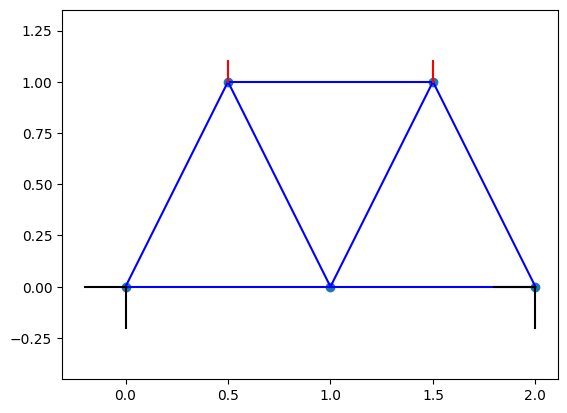

In [211]:
tr.plot()

In [212]:
print("\nNodos (x, y):\n", tr.nodes,"\n" )
print("Barras (i, j):\n", tr.bars,"\n")
print("Reacciones (nodo, x, y):\n", tr.reac,"\n")
print("Fuerzas externas (nodo, x, y):\n", tr.force,"\n")


Nodos (x, y):
 [[0.  0. ]
 [1.  0. ]
 [2.  0. ]
 [0.5 1. ]
 [1.5 1. ]] 

Barras (i, j):
 [[0 1]
 [1 2]
 [0 3]
 [3 1]
 [1 4]
 [4 2]
 [3 4]] 

Reacciones (nodo, x, y):
 [[0 1 0]
 [0 0 1]
 [2 1 0]
 [2 0 1]] 

Fuerzas externas (nodo, x, y):
 [[   3.    0. -500.]
 [   4.    0. -500.]] 



Generar el vector **f**, la Matriz **A**, la matriz de rigidez **km**, y la matriz de rigidez Global **K** :

In [213]:
f = generate_f(tr)
A = generate_A(tr)
km = generate_km(tr)
K = generate_K(A, km)


Alterar el orden de las filas de **k** y **f** , de tal manera que todas las filas relacionadas con una reacción esten arriba.

In [214]:
K_cambiada, combinations_list = swap_k_rows(tr, K)
swap_rows(f, combinations_list)

Obtener **K11**, **K12**, **K21** y **K21** en un diccionario:

In [215]:
submatrices = get_submatrices(K_cambiada, tr)  # Diccionario con cada submatriz

Obtener **fc** (fuerzas externas) :

In [216]:
fc = divide_f(generate_f(tr), tr)

Encontrar **Dxb** , siendo este el vector de los desplazamientos desconocidos en los nodos. *Dxc* es el vector desplazamiento de los nodos conocidos.

**Dxb** = **K22**^-1 (**fc** - **K21** **Dxc**)

con "**K22**^-1" la inversa de **K22**

ya que el vector **Dxc** siempre contiene desplazamientos iguales a cero (gracias a las reacciones), podemos simplificar la ecuación:

**Dxb** = **K22**^-1 **fc**

In [217]:
Dxb = (np.linalg.inv(submatrices["K22"])).dot(fc)
 
Dxc = []

for i in range(len(tr.reac)):
    Dxc.append(np.array([0]))
    

Reuniendo **Dxb** y **Dxc** , y reordenando sus filas:

In [218]:
DX = join_vectors(Dxc,Dxb)

combinations_list.reverse()  # Si damos vuelta la lista de combinaciones, podemos deshacer todos los intercambios de filas.

swap_rows(DX, combinations_list )

DX_array = []
for i in range(len(DX)):
    DX_array.append(DX[i][0])

DX = np.array(DX_array)

Calculando las reacciones **fb = R = K11 Dxc + K12 Dxb** , con **Dxc = 0**

In [219]:
R = submatrices["K12"].dot(Dxb)

Ahora, **F = f A^-1** , con **A^-1** la inversa de A :

In [220]:
# agregar los valores que ahora conocemos de R a f:

for i in range(len(R)):
    f[i] = R[i]


# Reordenar f:
swap_rows(f, combinations_list)

# Eliminar filas innecesesarias de A y f para lograr realizar las operaciones matriciales
size = len(tr.bars) 

A2 = keep_elements(A, size)
f2 = keep_elements(f, size)

# Finalmente calcular F:
F = np.linalg.solve(A2,f2)


## Finalmente, mostrar los resultados:
###### si las fuerzas y desplazamientos son de igual magnitud, pero de distintos signos a las correctas, se debe a un error al ultilizar los coeficientes tr.X(i,j) en la función generate_A(tr). Más información en la función.

Results, Force
Force Bar 0: -0.00
Force Bar 1: -0.00
Force Bar 2: -559.02
Force Bar 3: -0.00
Force Bar 4: 0.00
Force Bar 5: -559.02
Force Bar 6: -250.00
Reaction in node 0, components [1,0]: 250.00
Reaction in node 0, components [0,1]: 500.00
Reaction in node 2, components [1,0]: -250.00
Reaction in node 2, components [0,1]: 500.00
Displacement in node 0: [0.000000e+00,0.000000e+00]
Displacement in node 1: [-3.388132e-21,1.048858e-04]
Displacement in node 2: [0.000000e+00,0.000000e+00]
Displacement in node 3: [-4.448516e-05,-2.224258e-05]
Displacement in node 4: [-6.040065e-05,3.020033e-05]
[0.]
[0.]


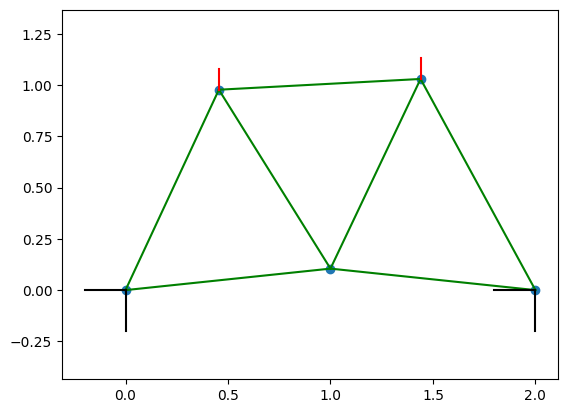

In [221]:
tr.print_results(DX,R,F)
tr.plot_deformed(DX,1000)

Hints:
- En `numpy`, si es que uno cuenta con un arreglo `A` de NxN y quiere obtener las filas especificadas en una lista `idx_f = [1, 2, 5]`, se puede hacer escribiendo `A[idx_f,:]`. De la misma manera si es que uno quisiera obtener las columnas `idx_c = [3, 4, 6]`, se escribe `A[:, idx_c]`. Finalmente si es que uno quiere obtener una sub-matriz de las filas y columnas especificadas en `idx_f` y `idx_c`, se logra con `A[np.array(idx_f)[:,None], np.array(idx_c)]`.
- Se pueden borrar elementos de una lista `a = [0, 1, 2, 3, 4]` simplemente con el comando `a.remove(x)` donde `x` es el elemento que uno quiere borrar, no la posición.
- `A.T` entrega el traspuesto del arreglo `A`.
- `A.dot(b)` corresponde a la multiplicación matricial. No use `A*b`.